# Финальный проект


# Вариант №1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

# Импорт библиотек, данных и получение первичной информации

In [1]:
# Библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import scipy.stats as st
from tqdm.auto import tqdm
import warnings


# Скрываем ошибки
import warnings
warnings.filterwarnings("ignore")

In [2]:
reg_df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-pilipchuk/shared/problem1-reg_data.csv", sep=';')
reg_df['reg_ts'] = pd.to_datetime(reg_df['reg_ts'], unit='s').dt.date
reg_df.head()

,reg_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,2000-01-13,3
3,2000-05-28,4
4,2000-09-16,5


In [3]:
auth_df = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-pilipchuk/shared/problem1-auth_data.csv", sep=';')
auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'], unit='s').dt.date
auth_df.head()

,auth_ts,uid
0,1998-11-18,1
1,1999-07-22,2
2,1999-07-25,2
3,1999-07-31,2
4,1999-08-05,2


# Мы имеем в данных:

reg_df – данные о времени регистрации

auth_df – данные о времени захода пользователей в игру

In [9]:
# первичное представление о данных 
for df in [auth_df, reg_df]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   auth_ts  object
 1   uid      int64 
dtypes: int64(1), object(1)
memory usage: 146.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   reg_ts  1000000 non-null  object
 1   uid     1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB
None


In [10]:
# проверим на пропуски
for df in [auth_df, reg_df]:
    print(df.isna().sum())

auth_ts    0
uid        0
dtype: int64
reg_ts    0
uid       0
dtype: int64


In [11]:
# проверим на дубликаты
for df in [auth_df, reg_df]:
    print(df.duplicated().sum())

0
0


Вывод: В данных всё хорошо, всё совпадает!

# Задание №1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Функция подсчета Retenion'a для выбранного интервала, зарегистрировавшихся в 
диапазоне start и end, диапазон разделяется на когорты по месяцу регистрации,
доля возвратов рассматривается в первые 14 дней на платформе относительно всех уникальных
пользователей в выбранных когортах

In [16]:
def calculate_retention(reg_df, auth_df, start, end, cohort_days):
    #преобразуем дату из Unix формата и оставим только дату
    reg_df['reg_ts'] = pd.to_datetime(reg_df['reg_ts'], unit='s').dt.date
    auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'], unit='s').dt.date
    #ограничиваем данные выбранным периодом
    reg_df = (reg_df[(reg_df['reg_ts'] >= (datetime.strptime(start, '%Y-%m-%d')).date()) 
                             & (reg_df['reg_ts'] <= (datetime.strptime(end, '%Y-%m-%d')).date())])
    auth_df = (auth_df[(auth_df['auth_ts'] >= (datetime.strptime(start, '%Y-%m-%d')).date()) 
                               & (auth_df['auth_ts'] <= (datetime.strptime(end, '%Y-%m-%d')).date())])
    #объединим датафреймы
    all_data = pd.merge(reg_df, auth_df, on='uid', how='left')
    #рассчитываем разницу в днях между датой регистрации и датой авторизации
    all_data['days_diff_reg'] = (all_data['auth_ts'] - all_data['reg_ts']).dt.days
    #ограничим данные количеством дней в когорте
    all_data = all_data[all_data['days_diff_reg'] <= cohort_days]
    #группируем данные по дате регистрации и количеству дней с момента регистрации
    retention_data = all_data.groupby(['reg_ts', 'days_diff_reg']).agg({'uid': 'nunique'}).reset_index()
    # переводим retention_data в формат когорт
    cohort_data = retention_data.pivot(index='reg_ts', columns='days_diff_reg', values='uid')
    #рассчитываем retention
    cohort_size = cohort_data.iloc[:,0]
    retention_rate = (cohort_data.divide(cohort_size, axis=0)).drop(columns=0)
    #визуализируем
    plt.figure(figsize=(18, 14))
    sns.heatmap(retention_rate, annot=True, fmt='.0%', cmap='twilight')
    plt.title('Retention Rates')
    plt.ylabel('Registration Date')
    plt.xlabel('Days since Registration')
    plt.show()
    
    return plt.show()

In [17]:
start = '2020-08-01'
end = '2020-08-31'
cohort_days = 15

In [18]:
reg_df_coh = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-pilipchuk/shared/problem1-reg_data.csv', sep=';')
auth_df_coh = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-pilipchuk/shared/problem1-auth_data.csv', sep=';')

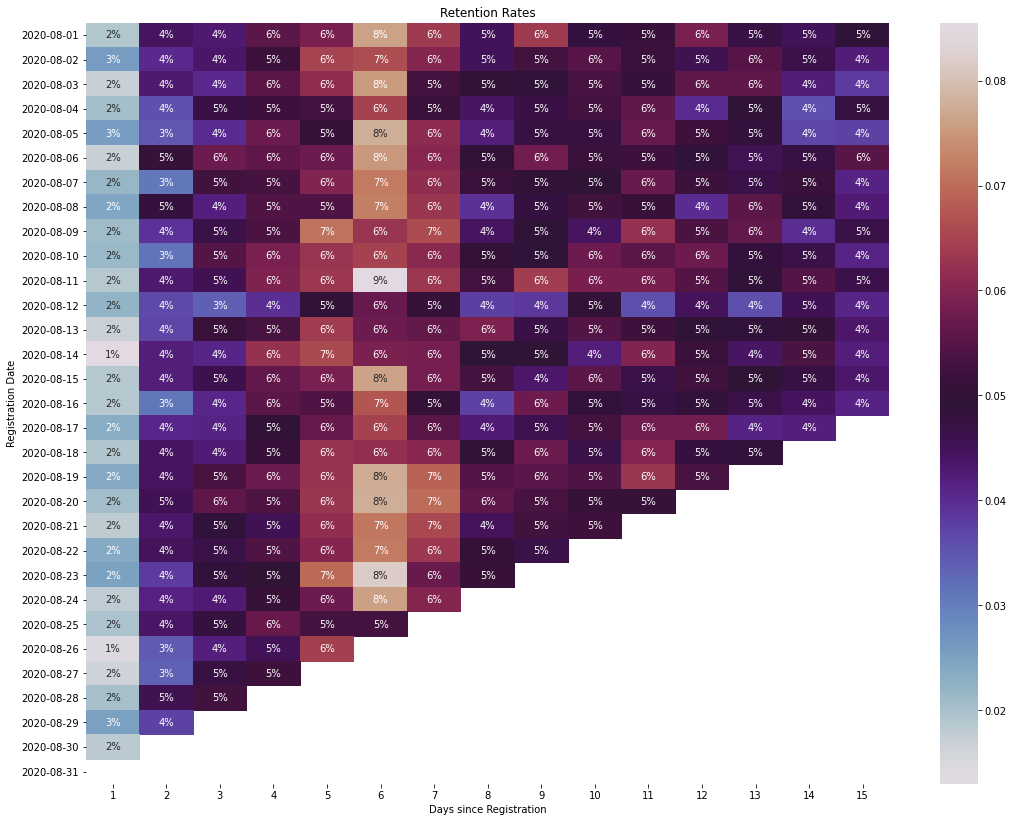

In [19]:
calculate_retention(reg_df_coh, auth_df_coh, start, end, cohort_days)

# Выводы:

Прослеживается тенденция увеличения возврата пользователей к 6-ому дню жизни, то есть примерно через неделю после регистрации, возможно связано со спецификой продукта, например в этот период настроена почтовая рассылка или пуш-уведомления, стимулирующие пользователей вернуться в игру (продукт). В целом кривая Retention'a напоминает график гиперболы, что похоже на классическое определение, из которого также можно проследить отток пользователей.

# Задание №2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [20]:
t2_df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-t-pilipchuk/Fin_p/Проект_1_Задание_2 (1).csv', sep=';')
t2_df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [35]:
# первичное представление о данных 
for df in [t2_df]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB
None


In [21]:
t2_df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

В датасете всё чисто, продолжим

In [23]:
# Метрики для обеих групп

users_a = t2_df.query('testgroup == "a"')['user_id'].nunique()
users_b = t2_df.query('testgroup == "b"')['user_id'].nunique()

pay_users_a = t2_df.query('testgroup == "a" & revenue > 0')['user_id'].nunique()
pay_users_b = t2_df.query('testgroup == "b" & revenue > 0')['user_id'].nunique()

conv_a = np.round(pay_users_a / users_a, 4)
conv_b = np.round(pay_users_b / users_b, 4) 

arpu_a = t2_df.query('testgroup == "a"')['revenue'].sum() / users_a
arpu_b = t2_df.query('testgroup == "b"')['revenue'].sum() / users_b

arppu_a = t2_df.query('testgroup == "a"')['revenue'].sum() / pay_users_a
arppu_b = t2_df.query('testgroup == "b"')['revenue'].sum() / pay_users_b

print('Группа A - {} пользователей, из них {} платящих c конверсией {}, ARPU: {:.3f}, ARPPU: {:.3f}'
      .format(users_a, pay_users_a, conv_a, arpu_a, arppu_a))
print('Группа B - {} пользователей, из них {} платящих c конверсией {}, ARPU: {:.3f}, ARPPU: {:.3f}'
      .format(users_b, pay_users_b, conv_b, arpu_b, arppu_b))

Группа A - 202103 пользователей, из них 1928 платящих c конверсией 0.0095, ARPU: 25.414, ARPPU: 2663.998
Группа B - 202667 пользователей, из них 1805 платящих c конверсией 0.0089, ARPU: 26.751, ARPPU: 3003.658


Так как процент платящих пользователей меньше 1%, то следует посмотреть на неплатящих пользователей

In [24]:
paying_groups_df = t2_df[t2_df['revenue'] > 0]  # Отбор пользователей с доходом > 0
paying_groups_df.head()

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a


Отфильтруем их по группам

In [25]:
paying_a = paying_groups_df.query('testgroup == "a"')[['revenue']]
paying_a.name = 'Group A'
paying_b = paying_groups_df.query('testgroup == "b"')[['revenue']]
paying_b.name = 'Group B'

Посмотрим на распределение по гистограмме

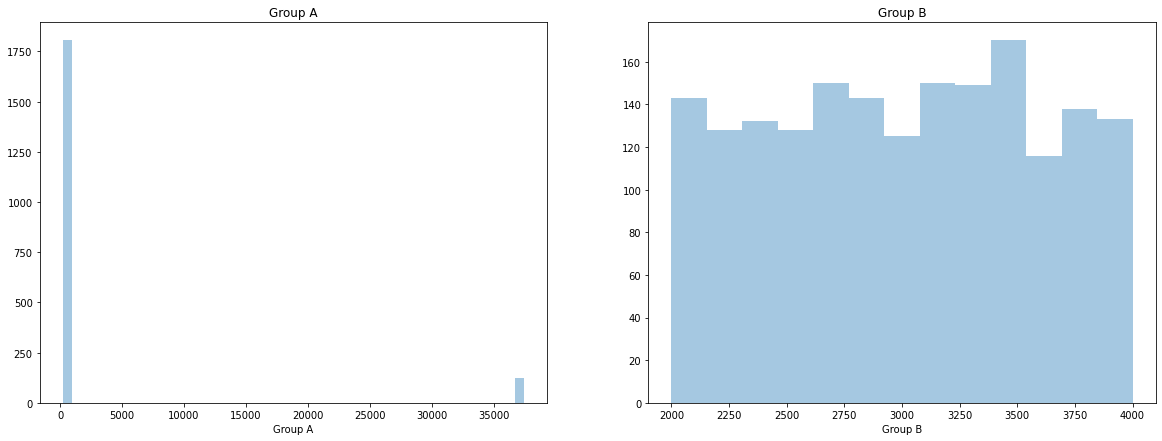

In [26]:
plt.figure(figsize=(20, 7)) 

for i,group in enumerate([paying_a, paying_b]):
    plt.subplot(1, 2, i+1)
    plt.title(group.name)
    sns.distplot(group, kde=False)

In [27]:
paying_a[paying_a.revenue > 1000].shape[0]

123

Количество пользователей группы A - принесшие большую прибыль.

In [28]:
# Доля прибыли с таких пользователей от общей прибыли
print('{:.2f}'.format(*paying_a.query('revenue > 30000').sum() / paying_a.sum()))

0.89


По результатам визуализаций можно сделать вывод, что в контрольной группе A присутствует небольшое количество пользователей, доход от которых значительно превышает среднее значение дохода в группе. Возможно, в контрольой группе были использованны акционные предложения, которые привлекли больше пользователей.

Какие есть варианты дальнейшего исследования:
1. Провести анализ результатов эксперимента для всех пользователей, включая тех, у кого доход равен нулю, и не удалять выбросы (учитываем конверсияю и ARPU).
2. Отфильтровать пользователей с высоким доходом, оставив тех, кто значительно отличается от остальных пользователей по уровню дохода (ARPPU, т.к. вычислить только на платящих пользователях не получится).
3. Удалить из выборки пользователей с нулевым доходом и тех, кто сильно отклоняется от основного распределения по уровню дохода (предполагаем, что система сплиования работает некорректно).

In [31]:
# Оценка статистических тестов на исходных группах
print('- Ст.отклонения группы A = {:.3f}, группы B = {:3f}'
          .format(np.std(paying_a)[0], np.std(paying_b)[0]))
print('- P-value для U-критерия Манна-Уитни = {:.3f}'
          .format(st.mannwhitneyu(paying_a.revenue, paying_b.revenue)[1]))
print('- P-value для т. Левена = {:.3f}'
          .format(st.levene(paying_a.revenue, paying_b.revenue)[1]))

- Ст.отклонения группы A = 9046.693, группы B = 572.461067
- P-value для U-критерия Манна-Уитни = 0.000
- P-value для т. Левена = 0.000


На основании полученных графиков и проведенных тестов, необходимо отметить следующее: условия для осознанного применения тестов не были выполнены, оценка теста Левена не позволяет утверждать о гомогенности дисперсий, а также распределения данных отличаются от нормальных, присутствует разное количество наблюдений между группами. Однако, согласно критерию Манна-Уитни, группы статистически значимо различаются, так как p-value для теста < 0.05 (при фиксированном уровне значимости и соответствующем уровне доверия). Сейчас мы точно не можем сказать, какая группа лучше.

Для более точных выводов и дальнейшего исследования сравнения групп, предлагается применить метод бутстрап на подвыборках платящих пользователей для оценки среднего показателя ARPPU. Таким образом, мы сможем провести статистический анализ и сделать выводы на основе более надежных данных.

In [32]:
def bootstrap(x, y, n, bootstrap_conf_level = 0.95):
    
    boot_len = max([len(x), len(y)])
    boot_data = []
    
    for i in tqdm(range(n)): 
        samples_1 = x.sample(boot_len, replace = True).values
        samples_2 = y.sample(boot_len, replace = True).values
        boot_data.append(np.mean(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(x = 0, loc = np.mean(boot_data), scale = np.std(boot_data))
    p_2 = st.norm.cdf(x = 0, loc = -np.mean(boot_data), scale = np.std(boot_data))
    p_value = min(p_1, p_2) * 2
        
    plt.figure(figsize=(10, 7))
    plt.hist(pd_boot_data[0], bins=50)
    plt.vlines(ci, 0, 600, linestyle='--', colors=['black'])
    plt.xlabel('mean_diff')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    print('2.5%-ый перцентиль:{:.2f}, 97.5%-ый перцентиль:{:.2f}, p-value: {:.3f}'
          .format(ci.values[0][0].astype('float64'), ci.values[1][0].astype('float64'), p_value))

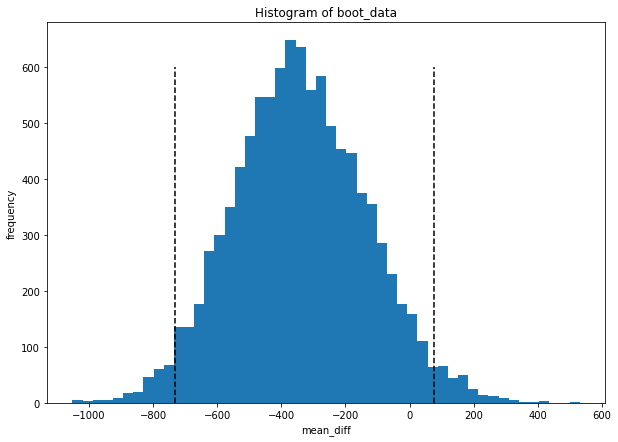

2.5%-ый перцентиль:-731.68, 97.5%-ый перцентиль:77.06, p-value: 0.099


In [33]:
bootstrap(paying_a, paying_b, 10000)

с вероятностью 95% у нас нет оснований отклонить нулевую гипотезу об отсутствии различий ARPPU в двух группах

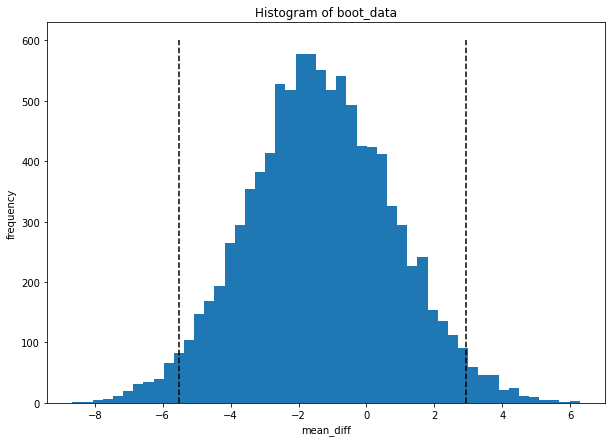

2.5%-ый перцентиль:-5.54, 97.5%-ый перцентиль:2.93, p-value: 0.531


In [34]:
# Используем бутстрап на группах, состоящих из всех пользователей вместе с неплатящими
bootstrap(t2_df.query('testgroup == "a"')['revenue'], 
          t2_df.query('testgroup == "b"')['revenue'], 
          10000)

с вероятностью 95% у нас нет оснований отклонить нулевую гипотезу об отсутствии различий ARPU в двух группах

# Выводы:

1. Распределение в группах одинаковое, что следует из p-value при использовании критерия Манна-Уитни;
2. При исследовании метрики ARPU тест подсказал не отклонять H0;
3. При исследовании метрики ARPPU в двух группах, также не выявил статистических различий;
4. При этом в платящих пользователях в контрольной группе у нас было 123 значимых клиента, которые оказали влияние на распределение revenue.

Однозначных выводов из полученных данных сделать нельзя, неизвестны разница между себестоимости товара и его рыночной ценой, сопутствующие затраты и цели проводимых акций

# Задание №3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### С помощью каких метрик можно оценить результаты последнего прошедшего события?
- Retention (возврат старых игроков, которые ранее были не активны, в разный временной промежуток)
- доля реактивированных игроков (которые вернулись, по каким-то причинам)
- DAU (активные игроки)
- ARPDAU (повышение средних чеков у активных игроков в дни проведения событий).

#### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?
Метрики значительно не поменяются, но я думаю такое решение, вероятно, приведет к оттоку пользователей, т.к. им будет невыгодно и неинтересно терять прогресс за уже купленные ими предметы в игре и заново проходить одни и те же уровни.